In [84]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


from amb_scripts.load_saved_info import *
from amb_scripts.utils import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *
from dag_prf_utils.utils import *
from dag_prf_utils.mesh_maker import *

from scipy.io import loadmat

from prfpy.rf import csenf_exponential

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
sub = 'sub-02'
qCSF_info = amb_load_qcsf(sub, eye_list=['L', 'R'])
roi_fit = 'all'
csf_data = amb_load_prf_params(
    sub=sub,
    task_list=['CSFLE', 'CSFRE'],
    model_list='csf',
    roi_fit=roi_fit, 
    fit_stage='grid'           
)

prf_obj = {}
for eye in ['L', 'R']:    
    prf_obj[eye] = Prf1T1M(csf_data[f'CSF{eye}E']['csf'], 'csf')


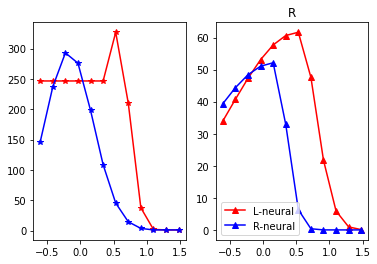

In [165]:
roi = 'not-V1_exvivo'
roi_mask = amb_load_roi(sub, roi)
rsq_th = 0.5
for eye in ['L', 'R']:    
    prf_obj[eye].rsq_w_mean(
        ['width_r','sf0','maxC','width_l'], 
        th={'min-rsq':rsq_th, 'roi':roi_mask})

# Compare eyes and behavioural vs neural
b_log_csf = {}
n_log_csf = {}
SFs = np.linspace(.25,10,50)
SFs = qCSF_info['L']['SF_list']
fig, ax = plt.subplots(1,2)
for eye in ['L', 'R']:
    b_log_csf[eye] = qcsf_curve(
        SFs,
        qCSF_info[eye]['peakCS'],
        qCSF_info[eye]['peakSF'],
        qCSF_info[eye]['bdwth'],
        qCSF_info[eye]['lowSFtrunc'],
    )
    n_log_csf[eye] = ncsf_curve(
        SFs, 
        prf_obj[eye].wm_param['width_r'], 
        prf_obj[eye].wm_param['sf0'], 
        prf_obj[eye].wm_param['maxC'], 
        prf_obj[eye].wm_param['width_l']    
        )
    # plt.figure()
    plt.title(eye)
    if eye=='L':
        col ='r'
    else:
        col='b'
    ax[0].plot(np.log10(SFs), 10**b_log_csf[eye], color=col, marker='*', label=f'{eye}-beh')
    ax[1].plot(np.log10(SFs), 10**n_log_csf[eye], color=col, marker='^', label=f'{eye}-neural')
    plt.legend()


In [69]:
# 
roi = 'all'
roi_fit = 'all'
roi_mask = amb_load_roi(sub, roi)
# prf_data = amb_load_prf_params(
#     sub=sub,
#     task_list=['pRFLE', 'pRFRE'],
#     model_list='gauss',
#     roi_fit=roi_fit,            
# )

csf_data = amb_load_prf_params(
    sub=sub,
    task_list=['CSFLE', 'CSFRE'],
    model_list='csf',
    roi_fit=roi_fit,            
)

# # Enter into prf objects:
prf_obj_list = []
prf_id_list = []
prf_obj = {}
# model = 'gauss'
# for task in ['pRFLE', 'pRFRE']:    
#     prf_obj[task] = {}    
#     # prf_obj[task][model] = Prf1T1M(prf_data[task][model], model)
#     prf_obj_list.append(Prf1T1M(prf_data[task][model], model, fixed_hrf=True))
#     prf_id_list.append(task)

model = 'csf'
for task in ['CSFLE', 'CSFRE']:    
    prf_obj[task] = {}    
    prf_obj[task][model] = Prf1T1M(csf_data[task][model], model)

    prf_obj_list.append(Prf1T1M(csf_data[task][model], model))
    prf_id_list.append(task)

all_prf_obj2 = PrfMulti(prf_obj_list, prf_id_list)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:279: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_sf0'] = np.log10(self.params_dd['sf0'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:280: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_maxC'] = np.log10(self.params_dd['maxC'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:282: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:282: RuntimeWarning: invalid value encountered in sqrt
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_ut

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/stimulus.py:252: RuntimeWarning: divide by zero encountered in log10
  self.log_SF_seq = np.log10(SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/stimulus.py:254: RuntimeWarning: divide by zero encountered in true_divide
  self.CON_S_seq = 100/CON_seq


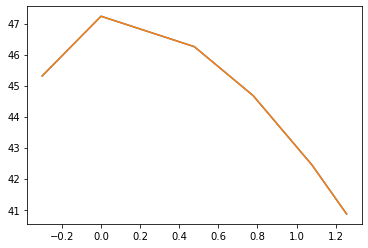

In [111]:
# Get weighted CSF parameters
SFs = np.linspace(1,10)
wm_LE = prf_obj['CSFLE']['csf'].rsq_w_mean(['width_r', 'sf0', 'maxC', 'width_l'])
csf_stim = amb_load_prfpy_stim('CSF')
_, csf_curve = csenf_exponential(
    csf_stim.log_SF_grid, 
    csf_stim.CON_S_grid, 
    wm_LE['width_r'], 
    wm_LE['sf0'], 
    wm_LE['maxC'], 
    wm_LE['width_l'], return_curve=True)    

plt.plot(csf_stim.log_SF_grid[0,:], csf_curve)
b_log_csf = {}
n_log_csf = {}
SFs = np.linspace(1,10,10)
for eye in ['L', 'R']:
    b_log_csf[eye] = qcsf_curve(
        SFs,
        qCSF_info[eye]['peakCS'],
        qCSF_info[eye]['peakSF'],
        qCSF_info[eye]['bdwth'],
        qCSF_info[eye]['lowSFtrunc'],
    )
    n_log_csf[eye] = ncsf_curve(
        SFs, 
        wm_LE['width_r'] * .1, 
        wm_LE['sf0'], 
        wm_LE['maxC'], 
        wm_LE['width_l']    

)

plt.plot(csf_stim.log_SF_grid[0,:], 10**a)


In [39]:
qCSFL.keys()
qCSFL.get('__header__')
# qCSFL['qcsf'].ravel()


b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Dec 22 16:35:10 2022'

In [156]:

fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer'
# LOAD USEFUL INFORMATION
roi_mask = amb_load_roi(sub, roi)
prf_data = amb_load_prf_params(
    sub=sub,
    task_list=['pRFLE', 'pRFRE'],
    model_list='gauss',
    roi_fit=roi_fit,            
)

csf_data = amb_load_prf_params(
    sub=sub,
    task_list=['CSFLE', 'CSFRE'],
    model_list='csf',
    roi_fit=roi_fit,            
)

# Enter into prf objects:
prf_obj_list = []
prf_id_list = []
prf_obj = {}
model = 'gauss'
for task in ['pRFLE', 'pRFRE']:    
    prf_obj[task] = {}    
    # prf_obj[task][model] = Prf1T1M(prf_data[task][model], model)
    prf_obj_list.append(Prf1T1M(prf_data[task][model], model, fixed_hrf=True))
    prf_id_list.append(task)

model = 'csf'
for task in ['CSFLE', 'CSFRE']:    
    prf_obj[task] = {}    
    # prf_obj[task][model] = Prf1T1M(csf_data[task][model], model, fixed_hrf=True)

    prf_obj_list.append(Prf1T1M(csf_data[task][model], model, fixed_hrf=True))
    prf_id_list.append(task)

all_prf_obj2 = PrfMulti(prf_obj_list, prf_id_list)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:279: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_sf0'] = np.log10(self.params_dd['sf0'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:280: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_maxC'] = np.log10(self.params_dd['maxC'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:282: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:282: RuntimeWarning: invalid value encountered in sqrt
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_ut

In [162]:
vx_mask = all_prf_obj1.return_vx_mask({'CSFLE-min-rsq':.1})
print((all_prf_obj1.prf_obj['CSFLE'].pd_params['rsq'][vx_mask]).mean())
vx_mask = all_prf_obj2.return_vx_mask({'CSFLE-min-rsq':.1})
print((all_prf_obj2.prf_obj['CSFLE'].pd_params['rsq'][vx_mask]).mean())

0.18230182940385464
0.16726249522995404


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


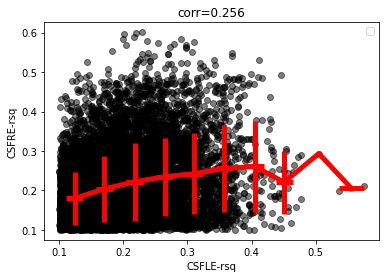

In [153]:
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFLE-hrf_deriv', alpha=0.5)
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFRE-hrf_deriv', alpha=0.5)
# all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFRE-hrf_deriv', alpha=0.5)
# all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFLE-hrf_deriv', alpha=0.5)

all_prf_obj.rapid_p_corr(
    'CSFLE-rsq',
    'CSFRE-rsq', 
    th={'CSFLE-min-rsq':.1, 'CSFRE-min-rsq':.1}, 
    do_line=True, line_col='r', dot_col='k', dot_alpha=.5)

In [54]:
prf_dE = Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['pRFRE']['gauss'], id1='prfLE', id2='prfRE')
csf_dE = Prf1T1Mx2(prf_obj['CSFLE']['csf'], prf_obj['CSFRE']['csf'], id1='csfLE', id2='csfRE')
le_dT =  Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['CSFLE']['csf'], id1='prfLE', id2='csfLE')
re_dT =  Prf1T1Mx2(prf_obj['pRFRE']['gauss'], prf_obj['CSFRE']['csf'], id1='prfRE', id2='csfRE')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


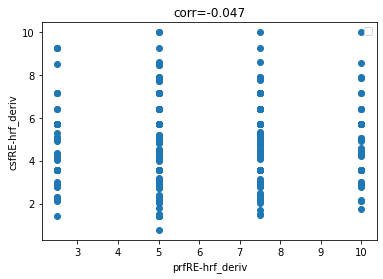

In [72]:
# prf_dE.rapid_p_corr(
#     'prfLE-hrf_deriv',
#     'prfRE-hrf_deriv'
# )
# plt.figure()
# csf_dE.rapid_p_corr(
#     'csfLE-hrf_deriv',
#     'csfRE-hrf_deriv'
# )

# plt.figure()
# le_dT.rapid_p_corr(
#     'csfLE-hrf_deriv',
#     'prfLE-hrf_deriv'
# )

roi = amb_load_roi(sub, 'demo-5000000')
plt.figure()
re_dT.rapid_p_corr(
    'prfRE-hrf_deriv',
    'csfRE-hrf_deriv',
    th={'all-min-rsq':.3, 'roi':roi},
)

In [36]:
fs = FSMaker(sub, fs_dir)

# POLAR 
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['pol'],
#         surf_name = f'{sub}-{task}-{model}-pol',    
#         vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'magmarev_magma', # using hsv for polar angle, can use something else...
#     )
#     POL CLOCK
#     clock_val = dag_pol_to_clock(prf_obj[task][model].pd_params['pol'])
#     fs.add_surface(
#         data = clock_val,
#         surf_name = f'{sub}-{task}-{model}-pol-clock',    
#         vmin = 0, vmax=12, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'twilight', # using hsv for polar angle, can use something else...
#         cmap_nsteps=20
#     )    
model = 'csf'
for task in ['CSFLE', 'CSFRE']:
    fs.add_surface(
        data = clock_val,
        surf_name = f'{sub}-{task}-{model}-pol-clock',    
        vmin = 0, vmax=12, # min and max values of polar anlge 
        data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
        cmap = 'twilight', # using hsv for polar angle, can use something else...
        cmap_nsteps=20
    )        


# # d_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['d_val'],
#         surf_name = f'{sub}-{task}-{model}-d_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'jet', # using hsv for polar angle, can use something else...
#     )


# # b_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['b_val'],
#         surf_name = f'{sub}-{task}-{model}-b_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'viridis', # using hsv for polar angle, can use something else...
#     )


# size_1
# model = 'gauss'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['size_1'],
#         surf_name = f'{sub}-{task}-{model}-size_1',    
#         vmin = 0, vmax=10, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'ecc', # using hsv for polar angle, can use something else...
#     )


Saving sub-01-pRFLE-gauss-pol-clock in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/custom
Saving sub-01-pRFRE-gauss-pol-clock in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/custom


In [37]:
fs.open_fs_surface(
    fs.surf_list, 
    mesh='inflated', 
    # roi_list=['v1custom', 'v2custom', 'v3custom', 'LOcustom']
    )

internal error:  void QXcbWindow::setNetWmStateOnUnmappedWindow() called on mapped window
internal error:  void QXcbWindow::setNetWmStateOnUnmappedWindow() called on mapped window


***

In [ ]:
# LOAD AND SAVE #
sub_list = [1,2,3,4,6]
dAS = {}
sAS = {}
for i,v in enumerate(sub_list):
    sub = f'sub-{v:02}'
    dAS[sub] = {}
    sAS[sub] = {}    
    print(sub)
    for task in ['AS1', 'AS2']:
        dAS[sub][task] = ScotShiftPlot(sub=sub, task_list=['AS0', task], model='gauss', sim_or_data='data')
        sAS[sub][task] = {}
        for model in ['gauss', 'norm']:
            sAS[sub][task][model] = ScotShiftPlot(sub=sub, task_list=['AS0', task], model=model, sim_or_data='sim')

In [ ]:
# LOAD AND SAVE #
sub_list = [1,2,3,4,6]

for i,v in enumerate(sub_list):
    sub = f'sub-{v:02}'
    for task in ['AS1', 'AS2']:
        plt.figure()
        dAS[sub][task].
        for model in ['gauss', 'norm']:

In [ ]:
sub = 'sub-01'
task_list = ['AS0', 'AS1']
dAS2g = ScotShiftPlot(sub=sub, task_list=task_list, model='gauss', sim_or_data='data')
sAS2g = ScotShiftPlot(sub=sub, task_list=task_list, model='gauss', sim_or_data='sim')
sAS2n = ScotShiftPlot(sub=sub, task_list=task_list, model='norm', sim_or_data='sim')


In [ ]:

sub_list = [1,2,3,4,6]
sub_task_rsq_max = {}
dAS = {}
sAS = {}
for i,v in enumerate(sub_list):
    sub = f'sub-{v:02}'
    print('sub')
    sub_task_rsq_max[sub] = {}
    for task in ['AS1', 'AS2']:
        dASXg = ScotShiftPlot(sub=sub, task_list=['AS0', task], model='gauss', sim_or_data='data')
        # sAS[task] = dASXg
        sub_task_rsq_max[sub][task] = {}
        for model in ['gauss', 'norm']:
            sASXm = ScotShiftPlot(sub=sub, task_list=['AS0', task], model=model, sim_or_data='sim')

            sub_task_rsq_max[sub][task][model] = []
            for rsq_max in np.r_[.1:1:.01]:
                vx_mask = dASXg.return_vx_mask({'all-min-rsq':.1, 'all-max-ecc':5})            
                vx_mask&= sASXm.return_vx_mask({'all-bound-rsq':[.1,rsq_max], 'all-max-ecc':5})
                if np.sum(vx_mask)<500:
                    corr = np.NaN
                else:
                    corr = dag_get_corr(
                        dASXg.pd_params['diff']['d2s_centre'][vx_mask],
                        sASXm.pd_params['diff']['d2s_centre'][vx_mask])
                sub_task_rsq_max[sub][task][model].append(corr)

In [ ]:
sub_list = [1,2,3,4,6]
AS_m = {'AS1':'+', 'AS2':'^'}
m_col = {'gauss':'g', 'norm':'r'}

for i,v in enumerate(sub_list):
    plt.figure()
    sub = f'sub-{v:02}'
    for task in ['AS1', 'AS2']:
        for model in ['gauss', 'norm']:
            plt.plot(sub_task_rsq_max[sub][task][model],f'-{AS_m[task]}{m_col[model]}', label=f'{task}-{model}')
    plt.legend()


In [ ]:
i_corr = []
for i in np.r_[.2:1:.01]:
    vx_mask = dAS2g.return_vx_mask(th={'all-min-rsq':.1,'all-max-ecc':5})
    vx_mask&= sAS2n.return_vx_mask(th={'all-bound-rsq':[.1,i], 'all-max-ecc':5})
    corr = dag_get_corr(
        dAS2g.pd_params['diff']['d2s_centre'][vx_mask],
        sAS2n.pd_params['diff']['d2s_centre'][vx_mask])
    i_corr.append(corr)
    # print(f'For {vx_mask.sum()} vx, & max rsq={i:.2f}, corr={corr:.3f}')

In [ ]:
plt.plot(i_corr)
plt.plot()

In [ ]:
sim_prf_obj = ScotShiftPlot(                                                         
    sub='sub-01',task_list=['AS0', 'AS1'],model='norm',
    sim_or_data='sim')  

In [ ]:
# Check the correlations: 
rsq_th = 0.1
ecc_th = 5
d2_corr = {
    'gauss' : np.zeros((6,2)), 
    'norm' : np.zeros((6,2)),
}
D_d2s_change = {}
S_d2s_change = {}
sub_list = [1,2,3,4,6]
for i,v in enumerate(sub_list):
    print('')
    sub = f'sub-{v:02}'
    D_d2s_change[sub] = {}
    for i_t,task in enumerate(['AS1', 'AS2']):
        D_d2s_change[sub][task] = {}
        S_d2s_change[sub][task] = {}
        for model in ['gauss', 'norm']:
            data_prf_obj = ScotShiftPlot( # ALWAYS GAUSS                                                        
                sub=sub,task_list=['AS0', task], model='gauss',
                sim_or_data='data')
            sim_prf_obj = ScotShiftPlot(                                                         
                sub=sub,task_list=['AS0', task],model=model,
                sim_or_data='sim')
            D_d2s_change[sub][task] = {}
            S_d2s_change[sub][task] = {}            
            this_vx_mask = sim_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})
            this_vx_mask &= data_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})                                   
            
            this_corr = np.corrcoef(
                data_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
                sim_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
            )[0,-1]
            d2_corr[model][i,i_t] = this_corr
            print(f'{sub}-{task}-{model: >5}: corr={this_corr:.3f}')

In [ ]:
# Check the correlations: 
rsq_th = 0.1
ecc_th = 5
d2_corr = {
    'gauss' : np.zeros((6,2)), 
    'norm' : np.zeros((6,2)),
}
D_d2s_change = {}
S_d2s_change = {}
sub_list = [1,2,3,4,6]
for i,v in enumerate(sub_list):
    print('')
    sub = f'sub-{v:02}'
    D_d2s_change[sub] = {}
    for i_t,task in enumerate(['AS1', 'AS2']):
        D_d2s_change[sub][task] = {}
        S_d2s_change[sub][task] = {}
        for model in ['gauss', 'norm']:
            data_prf_obj = ScotShiftPlot( # ALWAYS GAUSS                                                        
                sub=sub,task_list=['AS0', task], model='gauss',
                sim_or_data='data')
            sim_prf_obj = ScotShiftPlot(                                                         
                sub=sub,task_list=['AS0', task],model=model,
                sim_or_data='sim')
            D_d2s_change[sub][task] = {}
            S_d2s_change[sub][task] = {}            
            this_vx_mask = sim_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})
            this_vx_mask &= data_prf_obj.return_vx_mask({'all-min-rsq':rsq_th, 'all-max-ecc':ecc_th})                                   
            
            this_corr = np.corrcoef(
                data_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
                sim_prf_obj.pd_params['diff']['d2s_centre'][this_vx_mask],
            )[0,-1]
            d2_corr[model][i,i_t] = this_corr
            print(f'{sub}-{task}-{model: >5}: corr={this_corr:.3f}')

In [ ]:
sub = 'sub-01'
G0_d = ScotPrf1T1M(sub=sub, task='AS0', model='gauss', sim_or_data='data')
G1_d = ScotPrf1T1M(sub=sub, task='AS1', model='gauss', sim_or_data='data')
# G2_d = ScotPrf1T1M(sub=sub, task='AS2', model='gauss', sim_or_data='data')
# N0_d = ScotPrf1T1M(sub=sub, task='AS0', model='norm' , sim_or_data='data')
# N1_d = ScotPrf1T1M(sub=sub, task='AS1', model='norm' , sim_or_data='data')
# N2_d = ScotPrf1T1M(sub=sub, task='AS2', model='norm' , sim_or_data='data')


In [ ]:
G2_d = ScotPrf1T1M(sub=sub, task='AS2', model='gauss', sim_or_data='data')

In [ ]:

G0_s = ScotPrf1T1M(sub=sub, task='AS0', model='gauss', sim_or_data='sim')
G1_s = ScotPrf1T1M(sub=sub, task='AS1', model='gauss', sim_or_data='sim')
# G2_s = ScotPrf1T1M(sub=sub, task='AS2', model='gauss', sim_or_data='sim')
# N0_s = ScotPrf1T1M(sub=sub, task='AS0', model='norm' , sim_or_data='sim')
N1_s = ScotPrf1T1M(sub=sub, task='AS1', model='norm' , sim_or_data='sim')
N2_s = ScotPrf1T1M(sub=sub, task='AS2', model='norm' , sim_or_data='sim')


In [ ]:
N0_s = ScotPrf1T1M(sub=sub, task='AS0', model='norm' , sim_or_data='sim')

In [ ]:
G0_d.rapid_hist('rsq')
G1_d.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)

In [ ]:
G0_s.rapid_hist('rsq')
G1_s.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)
N0_s.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)
N1_s.rapid_hist(ax=plt.gca(), param='rsq', alpha=0.5)

In [ ]:
G1s_comp = Prf1T1Mx2(G0_s, G1_s, id1='G0_s', id2='G1_s')
N1s_comp = Prf1T1Mx2(N0_s, N1_s, id1='N0_s', id2='N1_s')
G1d_comp = Prf1T1Mx2(G0_d, G1_d, id1='G0_d', id2='G1_d')


In [ ]:
G1_s.rapid_scatter({'bound-rsq':[.3,.5]})

In [ ]:
G1s_comp.rapid_p_corr()

In [ ]:
comp = Prf1T1Mx2(
    N0_s, N1_s, id1='N0_s', id2='N1_s',
)
comp.rapid_p_corr('N0_s-ecc', 'N1_s-ecc')

In [ ]:
comp = Prf1T1Mx2(
    G0_d, G1_d, id1='G0_d', id2='G1_d',
)
comp.rapid_p_corr('G0_d-ecc', 'G1_d-ecc')

In [ ]:
vx_mask = 

In [ ]:
P_model_dict = {

    'G0_d': G0_d,
    'G1_d': G1_d,
    'G2_d': G2_d,
    'N0_d': N0_d,
    'N1_d': N1_d,
    'N2_d': N2_d,
    #
    'G0_s': G0_s,
    'G1_s': G1_s,
    'G2_s': G2_s,
    'N0_s': N0_s,
    'N1_s': N1_s,
    'N2_s': N2_s,    
}

In [ ]:
roi_mask = get_roi(sub, 'V1_exvivo')
s_id1 = 'N0_s'
s_id2 = 'N2_s'
d_id1 = 'G0_d'
d_id2 = 'G2_d'



fig,axs = plt.subplots(1)
fig.set_size_inches(10,10)
sim2 = Prf1T1Mx2(
    P_model_dict[s_id1],
    P_model_dict[s_id2],
    id1=s_id1, id2=s_id2)

sim2.rapid_arrow(th={'all-min-rsq':.1, 'roi':roi_mask, 'all-max-ecc':5}, arrow_col='angle')



fig,axs = plt.subplots(1)
fig.set_size_inches(10,10)
data2 = Prf1T1Mx2(
    P_model_dict[d_id1],
    P_model_dict[d_id2],
    id1=d_id1, id2=d_id2)
data2.rapid_arrow(th={'all-min-rsq':.1, 'roi':roi_mask, 'all-max-ecc':5}, arrow_col='angle')


In [ ]:
sub = 'sub-01'
task_list = ['AS0', 'AS1', 'AS2']
model_list = ['gauss', 'norm']
data_tc = load_data_tc(sub=sub, task_list=task_list)
d_pred_tc = load_data_prf(sub=sub, task_list=task_list, model_list=model_list, var_to_load='preds')
sim_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model_list)
s_pred_tc = load_sim_prf(sub=sub, task_list=task_list, model_list=model_list, var_to_load='preds')

In [ ]:
sim_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model_list)

In [ ]:
fig,ax = plt.subplots(1)
fig.set_size_inches(5,11)


In [ ]:
# Test whether subject stuff has been done: 
# -> [1] check for PSC 
# -> [2] check for 
source_data_dir = os.getenv("DIR_DATA_SOURCE")
derivatives_dir = os.getenv("DIR_DATA_DERIV")
default_prf_dir = opj(derivatives_dir, 'prf')
default_prf_xpred_dir = opj(derivatives_dir, 'prf_xpred')
default_ses = 'ses-1'
from dag_prf_utils.utils import *
def s0_checker(s, sub, **kwargs):
    roi_fit = kwargs.get('roi_fit', 'all')
    fit_stage = kwargs.get('fit_stage', 'iter')
    task = kwargs.get('task', '')
    model = kwargs.get('model', '')
    this_prf_dir = opj(default_prf_dir, sub, default_ses)
    this_xpred_dir = opj(default_prf_xpred_dir, sub, default_ses)
    if s=='s1':
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), 'hemi-LR', 'desc-avg_bold', '.npy'], 
            this_prf_dir, return_msg=None)    
    elif 's2' in s:
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), 'gauss', roi_fit, fit_stage, '.pkl'], 
            this_prf_dir, return_msg=None,)
    elif s=='s3':
        this_path = lsutils.get_file_from_substring(
            [sub, hyphen_parse('task', task), 'norm', roi_fit, fit_stage, '.pkl'], 
            this_prf_dir, return_msg=None)    
    elif s=='s4':
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), model, roi_fit, '.npy'], 
            this_xpred_dir, return_msg=None)    
    elif s=='s5':
        this_path = dag_find_file_in_folder(
            [sub, hyphen_parse('task', task), model, roi_fit, fit_stage, '.pkl'], 
            this_xpred_dir, return_msg=None)        
    if this_path is None:
        print(f'{s}, {sub}, {task}, {model}, NOT FOUND')
        sN_done = False
    else:
        sN_done = True
    
    return sN_done

        
            
for i in np.arange(1, 7):
    if i==5:
        continue
    sub = f'sub-{i:02}'
    for task in ['AS0', 'AS1', 'AS2']:
        s0_checker('s2', sub, task=task, )#model='gauss')
        s0_checker('s3', sub, task=task, )#model='gauss')
        # s0_checker('s4', sub, task=task, model='gauss')
        # s0_checker('s4', sub, task=task, model='norm')

        s0_checker('s5', sub, task=task, model='norm')
        s0_checker('s5', sub, task=task, model='gauss')
        # s0_checker('s2b', sub, task=task, )#model='gauss')

In [ ]:
for i in np.arange(1, 7):
    sub = f'sub-{i:02}'
    for task in ['AS0', 'AS1', 'AS2']:
        for model in ['gauss', 'norm']:
            try:
                ScotPrf1T1M(sub, task, model, sim_or_data='sim')
                print(f'{sub}, {task}, {model}')
            except:
                continue


In [ ]:
fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer'
from dag_prf_utils.mesh_maker import FSMaker
from dag_prf_utils.blender_tools import BlendMaker



In [ ]:
sub = 'sub-01'
prf_obj = ScotPrf1T1M(sub=sub, task='AS0', model='gauss')
fs = FSMaker(sub, fs_dir)


In [ ]:
sub = 'sub-01'
prf_obj = ScotPrf1T1M(sub=sub, task='AS0', model='gauss')
fs = FSMaker(sub, fs_dir)

fs.add_surface(
    data = prf_obj.pd_params['pol'],
    surf_name = f'{sub}-as0-gauss-pol',    
    vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
    data_mask=prf_obj.return_vx_mask({'min-rsq':.1}),
    cmap = 'pol', # using hsv for polar angle, can use something else...
)
fs.open_fs_surface(f'{sub}-as0-gauss-ecc')

In [ ]:
fs.add_surface(
    data = prf_obj.pd_params['ecc'],
    surf_name = f'{sub}-as0-gauss-ecc',    
    vmin = 0, vmax=5 , # min and max values of polar anlge 
    data_mask=prf_obj.return_vx_mask({'min-rsq':.1}),
    cmap = 'ecc', 
)
fs.open_fs_surface(f'{sub}-as0-gauss-ecc')

In [ ]:

# fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer'
# mesh_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/mesh_dir/'

# model = 'gauss'
# sub_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-06']
# task_list = ['AS0', 'AS1', 'AS2']
# for sub in sub_list:
#     out_dir = opj(mesh_dir, f'{sub}')
#     bm = BlendMaker(sub=sub, fs_dir=fs_dir,out_dir=out_dir, ow=True)
#     pred_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model)
#     notpsc_tc = load_data_not_psc(sub=sub, task_list=task_list, )
#     for task in task_list:
#         prf_obj = ScotPrf1T1M(sub=sub, task=task, model='gauss')
#         this_data_mask = prf_obj.return_vx_mask({'min-rsq':.1, 'max-ecc':5})
#         bm.add_cmap(
#             data=prf_obj.pd_params['ecc'], 
#             surf_name=f'G-{task}-ecc', 
#             vmin=0, vmax=5, 
#             cmap='ecc', data_mask=this_data_mask, )#ow=True)

#         bm.add_cmap(
#             data=prf_obj.pd_params['pol'], 
#             surf_name=f'G-{task}-pol', 
#             vmin=-np.pi, vmax=np.pi, 
#             cmap='pol', data_mask=this_data_mask,)# ow=True)

#         bm.add_cmap(
#             data=prf_obj.pd_params['rsq'], 
#             surf_name=f'G-{task}-rsq', 
#             vmin=0, vmax=1, 
#             cmap='cool', data_mask=this_data_mask,)# ow=True)

#         # amp
#         bm.add_cmap(
#             data=np.median(pred_tc[task][model], axis=-1),
#             surf_name=f'G-{task}-data-amp', 
#             cmap='cool', data_mask=this_data_mask,)# ow=True)        
        
#         bm.add_cmap(
#             data=np.max(notpsc_tc[task], axis=-1),
#             surf_name=f'G-{task}-data-max', 
#             cmap='cool',)# ow=True)                
#     bm.launch_blender(load_all_surf=True, save_blender=True, close_blender=True)

In [ ]:
bm.launch_blender(hemi_list='lh', mesh_list='inflated', surf_list='G-AS0-data-amp', save_blender=False, close_blender=False)

In [ ]:
    bm.add_cmap(data=g_prf_obj.pd_params['pol'], surf_name=f'G-{task}-pol', vmin=-3.14, vmax=3.14, cmap='hsv', data_mask=this_data_mask)
    bm.add_cmap(data=g_prf_obj.pd_params['rsq'], surf_name=f'G-{task}-rsq', vmin=0, vmax=1, cmap='cool', data_mask=this_data_mask)
    

In [ ]:
bm.launch_blender()

In [ ]:

prf_obj = Prf1T1M(g_prf, 'gauss', fixed_hrf=True)
# Add polar angle plot
fs.add_surface(
    data = g_prf.pd_params['pol'],
    surf_name = f'{sub}-as0-gauss-pol',    
    vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
    data_mask=g_prf.return_vx_mask({'min-rsq':.1}),
    cmap = 'hsv', # using hsv for polar angle, can use something else...

)

# Add eccentricity
fs.add_surface(
    data = g_prf.pd_params['ecc'],
    surf_name = f'{sub}-as0-gauss-ecc',   
    vmin = 0, vmax = 5, # min and max values of eccentricity
    data_mask=g_prf.return_vx_mask({'min-rsq':.1, 'max-ecc':8}),
    cmap = 'jet', # using jet for polar angle, can use something else...
)

In [ ]:
# Now we can open one of the surfaces in freeview
fs.open_fs_surface(
    surf_name=f'{sub}-as0-gauss-pol',
    mesh = 'inflated',          # what type of surface? inflated? pial?
    )

In [ ]:
from dag_prf_utils.mesh_maker import *


In [ ]:
load_data_tc(sub=sub, task_list='AS0', roi_fit='demo' )['AS0'].shape

In [ ]:
sub = 'sub-06'
task_list = ['AS0', 'AS1', 'AS2']
model_list = ['gauss', 'norm']
data_tc = load_data_tc(sub=sub, task_list=task_list)
prf_data = load_data_prf(sub=sub, task_list=task_list, model_list=model_list, roi_fit='demo')
sim_tc = load_sim_tc(sub=sub, task_list=task_list, model_list=model_list, roi_fit='demo')
prf_sim = load_sim_prf(sub=sub, task_list=task_list, model_list=model_list, roi_fit='demo')